# Import version2 data and module

In [2]:
'''import module'''

# basic tool
import os
from functools import reduce
import random

# model persistent
import pickle

# data process and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from feature_selector import FeatureSelector

# style and text
from matplotlib.font_manager import FontProperties

# fit model

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold

# tune
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [3]:
# fit function
# case輸入字串
# svm_ornot是否配適svm=>True:是,other:否
def fit_models(X_train, X_test, y_train, y_test, case, svm_ornot=False):
    
    # Logistic regression
    logmodel = LogisticRegression()
    logmodel.fit(X_train, y_train)
    print("-------------Logistic regression配適完成-----------------")
    pred_log = logmodel.predict_proba(X_test)
    auroc_log = roc_auc_score(y_test, pred_log[:, 1])
    print("-------------Logistic regression預測完成-----------------")
    
    # knn
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    print("-------------knn配適完成-----------------")
    pred_knn = knn.predict_proba(X_test)
    auroc_knn = roc_auc_score(y_test, pred_knn[:, 1])
    print("-------------knn預測完成-----------------")
    
    # random forest
    rf = RandomForestClassifier(n_estimators=600)
    rf.fit(X_train, y_train)
    print("-------------rf配適完成-----------------")
    pred_rf = rf.predict_proba(X_test)
    auroc_rf = roc_auc_score(y_test, pred_rf[:, 1])
    print("-------------rf預測完成-----------------")
    
    # XGBOOST
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    print("-------------xgb配適完成-----------------")
    pred_xgb = xgb.predict_proba(X_test)
    auroc_xgb = roc_auc_score(y_test, pred_xgb[:, 1])
    print("-------------xgb預測完成-----------------")
    
    # SVM(維度太高了電腦跑不動)
    if svm_ornot == True:
        svm = SVC(probability=True)
        svm.fit(X_train, y_train)
        print("-------------svc配適完成-----------------")
        pred_svm = svm.predict_proba(X_test)
        auroc_svm = roc_auc_score(y_test, pred_svm[:, 1])
        print("-------------svc預測完成-----------------")
    else:
        print("-------------不執行svm-----------------")
        pred_svm = False
        auroc_svm = False
        svm = False
    
    
    # inspection order
    print("")
    print("--------------------------------------------")
    print("類別順序log:", logmodel.classes_)
    print("類別順序knn:", knn.classes_)
    print("類別順序rf:", rf.classes_)
    print("類別順序xgb:", xgb.classes_)
    if svm_ornot == True:
        print("類別順序svm:", svm.classes_)
    else:
        print("類別順序svm:未配適")
    print("--------------------------------------------")
    print("")
    
    # call write_out_auroc
    write_out_auroc(auroc_log, auroc_knn, auroc_rf, auroc_xgb, auroc_svm, case)
    
    # call write_out_prob
    write_out_prob(pred_log, pred_knn, pred_rf, pred_xgb, pred_svm, case)
    
    # call write_out_model
    write_out_model(logmodel, knn, rf, xgb, svm, case)
    
    
def write_out_auroc(auroc_log, auroc_knn, auroc_rf, auroc_xgb, auroc_svm, case):
    
    # make df
    if auroc_svm is False:
        result_auroc = pd.DataFrame([[auroc_log, auroc_knn, auroc_rf, auroc_xgb, None]], 
                                    columns=["log", "knn", "rf", "xgb", "svm"])
    else:
        result_auroc = pd.DataFrame([[auroc_log, auroc_knn, auroc_rf, auroc_xgb, auroc_svm]], 
                                    columns=["log", "knn", "rf", "xgb", "svm"])
    
    # write out
    result_auroc.to_csv(case + "_auroc.csv", index=False)
    print("auroc資料順利傳出")
    
    
def write_out_prob(pred_log, pred_knn, pred_rf, pred_xgb, pred_svm, case):
    
    # make df
    df1 = pd.DataFrame(pred_log,columns=[("log", 0), ("log", 1)])
    df2 = pd.DataFrame(pred_knn,columns=[("knn", 0), ("knn", 1)])
    df3 = pd.DataFrame(pred_rf,columns=[("rf", 0), ("rf", 1)])
    df4 = pd.DataFrame(pred_xgb,columns=[("xgb", 0), ("xgb", 1)])
    if type(pred_svm) == bool:
        df5 = pd.DataFrame(None,columns=[("svm", 0), ("svm", 1)])
    else:
        df5 = pd.DataFrame(pred_svm,columns=[("svm", 0), ("svm", 1)])
    
    result_prob = pd.concat([df1, df2, df3, df4, df5], axis=1)
    result_prob.columns = pd.MultiIndex.from_tuples(result_prob.columns, names=['Method','class'])
    
    # write out
    result_prob.to_csv(case + "_prob.csv", index=False)
    print("prob資料順利傳出")
    
def write_out_model(logmodel, knn, rf, xgb, svm, case):
    
    model = [logmodel, knn, rf, xgb]
    filename = ["logmodel_" + case, "knn_" + case, "rf_" + case, "xgb_" + case]
    if svm != False:
        model.append(svm)
        filename.append("svm_" + case)
                
    # dump model(write out)
    for (mod, fil_name) in zip(model, filename): 
        pickle.dump(mod, open(fil_name, 'wb'))
    
    print("model順利儲存")
    

In [4]:
# draw chart
## pred_table:table of result
##  othercurve=DF(格式同pred_table)
# 使用前請確保y_test的值

def draw_chart(pred_table, case, svm_ornot=False, othercurve=False):
    # set font
    font_content = FontProperties(size=20)
    font_title = FontProperties(size=25)
    
    # data
    fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_table["log"]["1"], pos_label=1)
    fpr2, tpr2, thresholds2 = roc_curve(y_test, pred_table["knn"]["1"], pos_label=1)
    fpr3, tpr3, thresholds3 = roc_curve(y_test, pred_table["rf"]["1"], pos_label=1)
    fpr4, tpr4, thresholds4 = roc_curve(y_test, pred_table["xgb"]["1"], pos_label=1)
    if svm_ornot == True:    
        fpr5, tpr5, thresholds5 = roc_curve(y_test, pred_table["svm"]["1"], pos_label=1)
        
        
    xstandard = np.linspace(0, 1, 10)

    fig = plt.figure(figsize=[7, 5])
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(xstandard, xstandard, "--")
    ax.plot(fpr1, tpr1, label="log")
    ax.plot(fpr2, tpr2, label="knn")    
    ax.plot(fpr3, tpr3, label="rf")
    ax.plot(fpr4, tpr4, label="xgb")
    if svm_ornot==True:
        ax.plot(fpr5, tpr5, label="svm")
        
    # othercurve
    if othercurve is not False:
        #　加入othercurve
        pred_table = pd.concat([pred_table, othercurve], axis=1)
        # 刪除以配置好欄位
        pred_table = pred_table.drop(["log", "knn", "rf", "xgb", "svm"],axis=1)
        
        count = 0
        for (i,j) in pred_table.columns:
            count = count + 1
            # 是偶數(避免重複)(因奇偶數同)
            if count % 2 == 0:
                fpr, tpr, thresholds = roc_curve(y_test, pred_table[i][1], pos_label=1)
                ax.plot(fpr, tpr, label=i)

    # design
    ax.set_title("ROC curve(" + case + ")", fontproperties=font_title)
    ax.set_xlabel("False Positive Rate", fontproperties=font_content)
    ax.set_ylabel("True Positive Rate", fontproperties=font_content)
    ax.legend(fontsize="xx-large", loc=4)
    
    plt.show()

In [5]:
# working dir
working_path = r"D:\mypython_d\Cathay_Big_data_competition_2019"
os.chdir(working_path)

In [10]:
# import data
train_v2 = pd.read_csv("train_cleaned_version2_proc_tree.csv", low_memory=False, index_col=0)
test_v2 = pd.read_csv("test_cleaned_version2_proc_tree.csv", low_memory=False, index_col=0)

In [11]:
train_v2["Y1"].value_counts()

0    97827
1     1931
Name: Y1, dtype: int64

In [12]:
1931*100 / (97827 + 1931)

1.9356843561418633

# Train_test_split

In [13]:
X = train_v2.drop("Y1", axis=1)
y = train_v2["Y1"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [15]:
# 驗證分層抽樣比例
print(y_train.value_counts())
print(y_test.value_counts())
print("y_train 0比例:",65543*100/(65543 + 1294) )
print("y_train 1比例:",1294*100/(65543 + 1294) )
print("y_test 0比例:", 32284*100/(32284 + 637))
print("y_test 1比例:", 637*100/(32284 + 637))

0    65543
1     1294
Name: Y1, dtype: int64
0    32284
1      637
Name: Y1, dtype: int64
y_train 0比例: 98.06394661639511
y_train 1比例: 1.9360533836048894
y_test 0比例: 98.06506485222198
y_test 1比例: 1.9349351477780141


# Fit model1 : without any further processing(v2_1)
Note:occupation欄位已為順序尺度

In [16]:
fit_models(X_train, X_test, y_train, y_test, "v2_1")

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


-------------Logistic regression配適完成-----------------
-------------Logistic regression預測完成-----------------
-------------knn配適完成-----------------
-------------knn預測完成-----------------
-------------rf配適完成-----------------
-------------rf預測完成-----------------
-------------xgb配適完成-----------------
-------------xgb預測完成-----------------
-------------不執行svm-----------------

--------------------------------------------
類別順序log: [0 1]
類別順序knn: [0 1]
類別順序rf: [0 1]
類別順序xgb: [0 1]
類別順序svm:未配適
--------------------------------------------

auroc資料順利傳出
prob資料順利傳出
model順利儲存


In [17]:
result1 = pd.read_csv("v2_1_prob.csv", header=[0, 1])

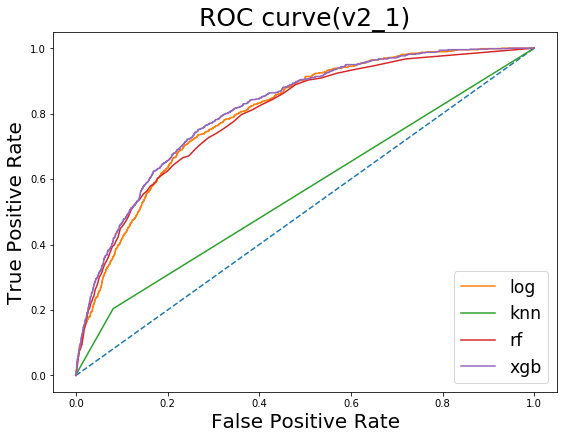

In [18]:
draw_chart(result1, case="v2_1")

## Submission

##### XGBOOST

In [19]:
# read model and submission_testset
xgb_v2_1 = pickle.load(open("xgb_v2_1", 'rb'))
xgb_v2_1_submission = xgb_v2_1.predict_proba(test_v2)[:, 1]


In [20]:
submission_file = pd.DataFrame(test_v2.index, columns=["CUS_ID"])
xgb_v2_1_submission = pd.DataFrame(xgb_v2_1_submission, columns=["Ypred"])

In [21]:
xgb_v2_1_submission = pd.concat([submission_file, xgb_v2_1_submission], axis=1)

In [22]:
xgb_v2_1_submission.to_csv("xgb_v2_1_submission.csv", index=False)

##### Logistic regression

In [23]:
# read model and submission_testset
logmodel_v2_1 = pickle.load(open("logmodel_v2_1", 'rb'))
logmodel_v2_1_submission = logmodel_v2_1.predict_proba(test_v2)[:, 1]

In [24]:
submission_file = pd.DataFrame(test_v2.index, columns=["CUS_ID"])
logmodel_v2_1_submission = pd.DataFrame(logmodel_v2_1_submission, columns=["Ypred"])

In [25]:
logmodel_v2_1_submission = pd.concat([submission_file, logmodel_v2_1_submission], axis=1)

In [26]:
logmodel_v2_1_submission.to_csv("logmodel_v2_1_submission.csv", index=False)

# Fit model2: After processing、tune
XGB、RF => no further address, only tune(資料同model1)

LOG、KNN => One-hot encoding, and tune

In [6]:
train_v2_proc_tree = pd.read_csv("train_cleaned_version2_proc_tree.csv", low_memory=False, index_col=0)
train_v2_proc_nontree = pd.read_csv("train_cleaned_version2_proc_nontree.csv", low_memory=False, index_col=0)

# 1. For tree

## use the same way to split(same random state)

In [7]:
X = train_v2_proc_tree.drop("Y1", axis=1)
y = train_v2_proc_tree["Y1"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [9]:
# 驗證分層抽樣比例
print(y_train.value_counts())
print(y_test.value_counts())
print("y_train 0比例:",65543*100/(65543 + 1294) )
print("y_train 1比例:",1294*100/(65543 + 1294) )
print("y_test 0比例:", 32284*100/(32284 + 637))
print("y_test 1比例:", 637*100/(32284 + 637))

0    65543
1     1294
Name: Y1, dtype: int64
0    32284
1      637
Name: Y1, dtype: int64
y_train 0比例: 98.06394661639511
y_train 1比例: 1.9360533836048894
y_test 0比例: 98.06506485222198
y_test 1比例: 1.9349351477780141


# Tune(Grid search )
參考:https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [10]:
# hyperparameter
param_grid = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25] , 
              "max_depth": [3, 5, 7, 9, 12], 
              "min_child_weight": [1, 3], 
              "gamma": [0.0, 0.1, 0.2], 
              "colsample_bytree": [0.3, 0.5, 0.7, 1] }


In [11]:
grid1 = GridSearchCV(XGBClassifier(), param_grid, verbose=5, scoring="roc_auc")
grid1.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.7980851709453869, total=  13.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8091729103249534, total=  13.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.3s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8006589169967854, total=  13.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.8s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.7982958012937874, total=  13.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   56.8s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.808158466298688, total=  13.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8008918170312691, total=  13.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.8073381261273174, total=  16.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.8245184935190275, total=  16.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.812458601

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8253596489485991, total=  15.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8082943857900375, total=  18.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.82765517250168, total=  18.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8156649858852808, total=  18.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.8111313265389153, t

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.7825784651023231, total=  21.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.8116768162397701, total=  22.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.7913931489582104, total=  22.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.7911703927471962, total=  21.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.82105589

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7864769752799556, total=  27.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7730455539935666, total=  27.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.7676528468577513, total=  26.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.7962810551024968, total=  26.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.77223497

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8006589169967854, total=  12.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.7983098927607578, total=  12.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8090388369846593, total=  12.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.800906897653657, total=  12.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.807467439

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8164090047228664, total=  15.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8304343402763323, total=  15.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8266262619268341, total=  14.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8079428937473725, total=  18.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8295883773228405,

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8215666499017468, total=  18.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8047995036563607, total=  18.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.7883770507852232, total=  21.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.8135802328851266, total=  22.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.79733433

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7899997844108207, total=  21.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7648737023136282, total=  27.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7897642942889112, total=  27.4s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7754389124874669, total=  27.7s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.766021415

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.7980875548401751, total=  12.0s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8084143472598276, total=  12.1s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8006702274635764, total=  12.1s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.7983250967119628, total=  12.1s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.80819128

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8323507660180738, total=  15.0s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8264723227567548, total=  15.1s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8172063910418108, total=  15.0s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8317984900527671, total=  14.9s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8234925723155668,

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8090718864594809, total=  18.4s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8027756693552761, total=  18.1s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8237835061224524, total=  18.2s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8155784316088995, total=  18.1s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.78175681

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7862929969859094, total=  21.3s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7970435474457143, total=  21.4s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7921150541038569, total=  21.4s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7551829051222589, total=  27.2s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7867895121833

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.780862992657135, total=  26.1s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7700938407658321, total=  26.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8019535435059739, total=  14.6s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8101114768053652, total=  14.4s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.803559

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8180938688030457, total=  14.3s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8149572657722718, total=  18.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8295230663491526, total=  19.0s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8243939581079427, total=  18.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8155184875808617,

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7995805616583261, total=  23.7s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8115940359080795, total=  23.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.808248134011933, total=  23.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.7972138838880074, total=  23.6s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.815899144

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7900298391502225, total=  29.2s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7809611284213763, total=  28.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7804844519203384, total=  28.7s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.791793713324968, total=  28.5s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7856748318324751, 

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7710538498227018, total=  37.5s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7552642753976972, total=  35.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7814525436659612, total=  35.8s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.767754698171432, total=  35.9s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.80

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8141532045479204, total=  21.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8257756501149898, total=  20.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8180938688030457, total=  17.1s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8151800274963723, total=  23.7s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8285685703629633,

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8247887641337195, total=  18.8s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8199724683060011, total=  18.8s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7953400896090159, total=  23.8s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8111343634696927, total=  23.8s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.80101745

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7999168866543607, total=  23.7s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7699734359954975, total=  29.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7885335806725395, total=  29.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7814467881832066, total=  29.1s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7803395111172138,

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7668334227558756, total=  37.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.778447707892794, total=  37.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7659135878213142, total=  37.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7490409326389736, total=  36.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8260229291430096, total=  14.3s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8174397733573617, total=  14.4s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8105268767714987, total=  14.5s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8257756501149898, total=  14.3s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8180938688030457,

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8161470878946464, total=  34.4s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8081801177665215, total=  34.9s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.825942378942128, total=  34.1s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.822698237701832, total=  34.0s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7995187393

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8028074016436796, total=  42.0s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8023258246598944, total=  42.6s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7909464651711433, total=  43.1s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7801423365305071, total=  53.0s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7906930375740934,

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7902869944718243, total=  51.0s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7753980779852968, total=  55.4s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.76649014190637, total= 1.2min
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7803783108946775, total= 1.1min
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7645

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8119614186702566, total= 1.4min
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8107196014212675, total=  30.0s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8275604981390089, total=  30.0s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8181879633906209, total=  30.1s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.809227866013670

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8068390974849804, total=  26.0s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8229772607366993, total=  24.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8124158020708668, total=  25.8s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8044460379456718, total=  26.5s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.82321684

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7942268922341323, total=  33.4s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7896982781646288, total=  32.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7866283315194543, total=  30.0s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8087851330559759, total=  30.1s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7974061754299065,

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7662500343827571, total=  36.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7658992008760866, total=  36.5s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7787334301280903, total=  36.2s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7654756125626682, total=  43.8s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.763343

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8068621947767064, total=  48.1s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8246173626515534, total=  47.3s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8150323431559515, total=  47.1s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8107196014212675, total=  16.9s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8275604

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8278580082085805, total=  16.9s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8158583258363878, total=  16.9s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8059024917104032, total=  23.0s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8235384572252415, total=  23.0s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.81374061

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8073163214708662, total=  23.5s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7850228578427383, total=  29.5s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8006337394578531, total=  29.6s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7842797149592446, total=  29.9s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7886949034236543,

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7556082979033591, total=  39.8s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7787923162011144, total=  38.2s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7715674936972026, total=  38.2s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7645323815553927, total=  37.3s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.78820766

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8267539872614927, total=  56.5s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8064796124322526, total=  53.4s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.809099453547744, total=  50.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8265818424023903, total=  51.2s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=1, score=0.8172908256608897, total=  18.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8107872510578136, total=  20.2s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8278580082085805, total=  20.2s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8158583258363878, total=  19.2s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.80974342

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8007098920826723, total=  29.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.816795231937852, total=  25.0s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8071676392783094, total=  22.9s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7802212699357176, total=  29.9s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7940434374259278, 

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.793244041727659, total=  32.8s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7891800145220023, total=  31.8s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7662449185958202, total=  38.1s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7878331603035017, total=  37.8s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.775209835

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.7951252742008761, total= 1.3min
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8146338103972521, total= 1.1min
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8039932213664382, total= 1.2min
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8002692423749271, total= 1.2min
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8193341827653793,

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, score=0.8168566736586238, total=  20.1s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8104193366288295, total=  20.2s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8248351189955321, total=  20.1s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8219543488320005, total=  20.8s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8036596175427533, total=  

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8102243108046226, total=  28.4s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8066991310694063, total=  28.4s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7821047587201811, total=  37.7s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8053110140426027, total=  37.6s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.786070167162327, total=  37.6s
[CV]

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7650225103238537, total=  49.0s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7766816035872397, total=  50.0s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7780963942762879, total=  48.4s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7656934972435818, total=  47.5s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7815045269531486, total=  

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8030208929278997, total= 1.1min
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8023442373740455, total= 1.0min
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8206829871179149, total= 1.0min
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8114390131665516, total= 1.0min
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.811312343616502, tota

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8250586099615909, total=  20.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8219543488320005, total=  20.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8066348771647883, total=  28.6s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8173532425252387, total=  28.6s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8067076271946951, total=  

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7840377265653606, total=  37.5s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.792650826932504, total=  37.6s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7839335509545026, total=  37.7s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7860471909455226, total=  38.0s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7983078192209241, total=  37.5s
[CV]

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7740306797208216, total=  48.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7570935703073084, total=  46.7s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7880528281881738, total=  47.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7730150741440923, total=  47.3s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.763383556169223, total= 

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.821794760424481, total= 1.1min
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8105910998627133, total= 1.1min
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.811312343616502, total=  20.6s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8242887900457155, total=  21.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8168787104835921, total=  21.1s

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8058542840602412, total=  29.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8192101450137248, total=  30.2s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8091429884079928, total=  30.8s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8103710760032277, total=  31.4s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8233000456221046, total=  

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7938785311091469, total=  45.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7793521548713671, total=  42.6s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8021849016321159, total=  41.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7909654221506943, total=  40.2s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.772417404932395, total=  51.5s
[CV]

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7747959748900013, total=  51.3s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.779706516220112, total=  51.8s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7640246649409387, total= 1.2min
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7875529602968749, total= 1.2min
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7774375728609119, tot

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 956.6min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25], 'max_depth': [3, 5, 7, 9, 12], 'min_child_weight': [1, 3], 'gamma': [0.0, 0.1, 0.2], 'colsample_bytree': [0.3, 0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [12]:
filename = "xgb_v2_2"
pickle.dump(grid1, open(filename, 'wb'))

In [13]:
xgb_v2_2 = pickle.load(open("xgb_v2_2", 'rb'))

In [14]:
xgb_v2_2.score(X_test, y_test)

0.8216973545420188

## Submission

##### Xgboost

In [15]:
# import test data
test_v2_proc_tree = pd.read_csv("test_cleaned_version2_proc_tree.csv", low_memory=False, index_col=0)

In [16]:
# read model and submission_testset
xgb_v2_2 = pickle.load(open("xgb_v2_2", 'rb'))
xgb_v2_2_submission = xgb_v2_2.predict_proba(test_v2_proc_tree)[:, 1]

In [17]:
submission_file = pd.DataFrame(test_v2_proc_tree.index, columns=["CUS_ID"])
xgb_v2_2_submission = pd.DataFrame(xgb_v2_2_submission, columns=["Ypred"])

In [18]:
xgb_v2_2_submission = pd.concat([submission_file, xgb_v2_2_submission], axis=1)

In [19]:
xgb_v2_2_submission.to_csv("xgb_v2_2_submission.csv", index=False)
# pd.read_csv("xgb_v1_2_submission.csv")